<a href="https://colab.research.google.com/github/antonitsin/sim/blob/master/2021_11_23_simulation_ci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.stats import binom_test
from scipy import stats as st
import pandas as pd
import numpy as np
import random as rd
from random import choices
from matplotlib import pyplot as plt
from statsmodels.stats.power import tt_ind_solve_power
plt.style.use('seaborn-whitegrid')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Lets calculate sample size for 80% power test, two-sided, alpha = 0.05

In [2]:
from statsmodels.stats.power import tt_ind_solve_power

mean_diff, sd_diff = 1, 25
std_effect_size = mean_diff / sd_diff

n = tt_ind_solve_power(effect_size=std_effect_size, alpha=0.05, power=0.8, ratio=1, alternative='two-sided')
print('Number in *each* group: {:.5f}'.format(n))

Number in *each* group: 9812.03624


In [3]:
columns = ['success_share','real_diff', 'pvalue', 'test_mean', 'control_mean', 'test_higher_control', 'control_higher_test', 'statsig80', 'statsig90', 'statsig95']
data = []
for success_share in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
  for i in range(100000):
    coin = np.random.binomial(1, success_share)
    test = np.random.normal(loc = 40 + coin, scale = 25, size=9812)
    control = np.random.normal(loc = 40 , scale = 25, size = 9812)
    result = st.ttest_ind(test, control, equal_var=True)
    data.append([success_share, coin, result.pvalue, test.mean(), control.mean(), test.mean()>control.mean(), control.mean()>test.mean(), result.pvalue<0.2, result.pvalue<0.1, result.pvalue<0.05])

df0 = pd.DataFrame(data, columns=columns)
df0.head(10)

,success_share,real_diff,pvalue,test_mean,control_mean,test_higher_control,control_higher_test,statsig80,statsig90,statsig95
0,0.05,0,0.514682,40.369547,40.137929,True,False,False,False,False
1,0.05,0,0.852731,39.606432,39.672429,False,True,False,False,False
2,0.05,0,0.042044,39.525605,40.258224,False,True,True,True,True
3,0.05,0,0.999112,39.803982,39.803584,True,False,False,False,False
4,0.05,0,0.746221,39.977775,39.863329,True,False,False,False,False
5,0.05,0,0.529429,40.183133,39.959895,True,False,False,False,False
6,0.05,0,0.860586,40.100589,40.038007,True,False,False,False,False
7,0.05,1,0.000581,41.508871,40.283637,True,False,True,True,True
8,0.05,0,0.378669,40.039213,40.351985,False,True,False,False,False
9,0.05,0,0.680229,40.281969,40.134986,True,False,False,False,False


# False Discovery Rate

In [4]:
columns = ['ci','success_share', 'frr']
data2 = []
for  success_share in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
  df1 = df0[df0.success_share==success_share]
  data2.append(["95", success_share,  df1[(df1.real_diff==1) & (df1.statsig95) & (df1.test_higher_control)].statsig95.count() / df1[(df1.statsig95) & (df1.test_higher_control)].statsig95.count()])
  data2.append(["90", success_share,  df1[(df1.real_diff==1) & (df1.statsig90) & (df1.test_higher_control)].statsig90.count() / df1[(df1.statsig90) & (df1.test_higher_control)].statsig90.count()])
  data2.append(["80", success_share,  df1[(df1.real_diff==1) & (df1.statsig80) & (df1.test_higher_control)].statsig80.count() / df1[(df1.statsig80) & (df1.test_higher_control)].statsig80.count()])

In [5]:
data2
df1 = pd.DataFrame(data2, columns=columns)
df1

,ci,success_share,frr
0,95,0.05,0.621492
1,90,0.05,0.477359
2,80,0.05,0.326758
3,95,0.10,0.784181
4,90,0.10,0.659132
5,80,0.10,0.502766
6,95,0.20,0.891692
7,90,0.20,0.813931
8,80,0.20,0.699528
9,95,0.30,0.934179


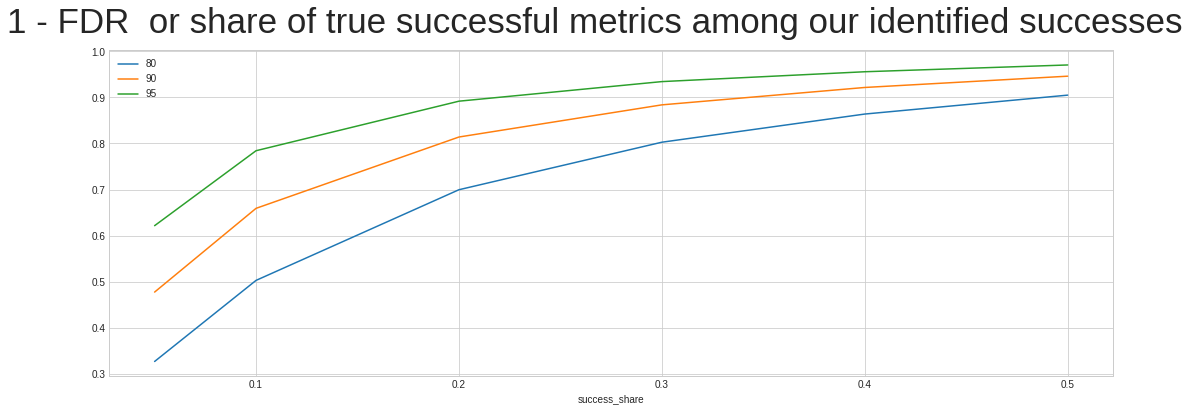

In [6]:
fig, ax = plt.subplots()
for label, grp in df1.groupby('ci'):
    grp.plot(x = 'success_share', y = 'frr',ax = ax, label = label)
    fig.set_size_inches(18, 6)
#     ax.get_legend()
plt.suptitle('1 - FDR  or share of true successful metrics among our identified successes', fontsize=35 );

# Type 1 error: False positive

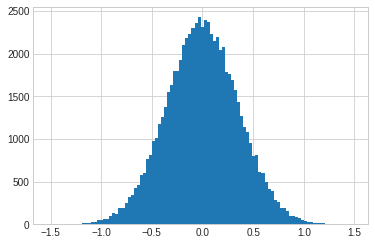

In [7]:
(df0[(df0.success_share==0.3) & (df0.real_diff==0)].test_mean - df0[(df0.success_share==0.3) & (df0.real_diff==0)].control_mean).hist(bins=100)

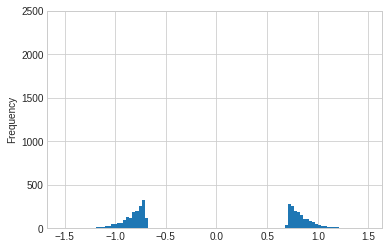

In [8]:
(df0[(df0.success_share==0.3) & (df0.real_diff==0) & (df0.statsig95==1)].test_mean - df0[(df0.success_share==0.3) & (df0.real_diff==0)& (df0.statsig95==1)].control_mean).plot.hist(bins=100, ylim=(0,2500))

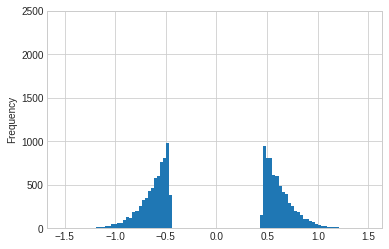

In [9]:
(df0[(df0.success_share==0.3) & (df0.real_diff==0) & (df0.statsig80==1)].test_mean - df0[(df0.success_share==0.3) & (df0.real_diff==0)& (df0.statsig80==1)].control_mean).plot.hist(bins=100, ylim=(0,2500))

In [10]:
columns = ['ci','success_share', 'frr']
data2 = []
for  success_share in [0.1, 0.2, 0.3, 0.4, 0.5]:
  df1 = df0[df0.success_share==success_share]
  data2.append(["95", success_share,  df1[(df1.real_diff==0) & (df1.statsig95) & (df1.test_higher_control)].statsig95.count() / df1[df1.real_diff==0].statsig95.count()])
  data2.append(["90", success_share,  df1[(df1.real_diff==0) & (df1.statsig90) & (df1.test_higher_control)].statsig90.count() / df1[df1.real_diff==0].statsig90.count()])
  data2.append(["80", success_share,  df1[(df1.real_diff==0) & (df1.statsig80) & (df1.test_higher_control)].statsig80.count() / df1[df1.real_diff==0].statsig80.count()])

In [11]:
data2
df1 = pd.DataFrame(data2, columns=columns)
df1

,ci,success_share,frr
0,95,0.1,0.024439
1,90,0.1,0.050043
2,80,0.1,0.101739
3,95,0.2,0.024163
4,90,0.2,0.049810
5,80,0.2,0.100045
6,95,0.3,0.024151
7,90,0.3,0.049417
8,80,0.3,0.098533
9,95,0.4,0.025168


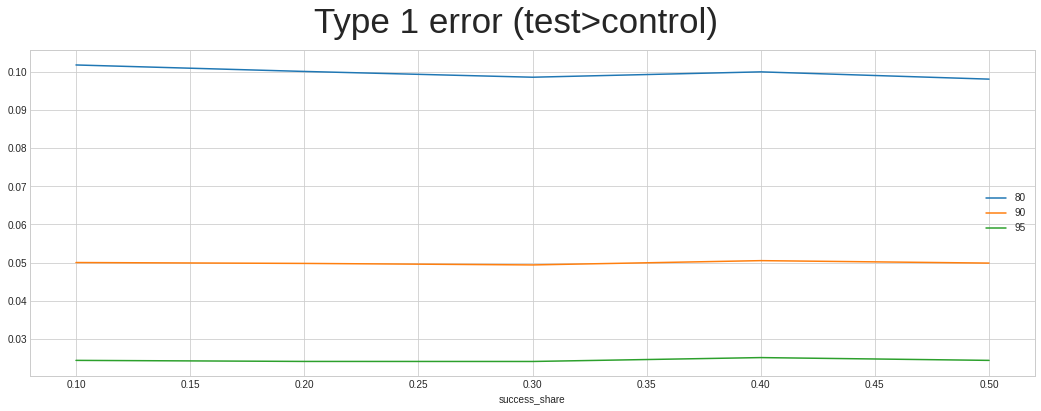

In [12]:
fig, ax = plt.subplots()
for label, grp in df1.groupby('ci'):
    grp.plot(x = 'success_share', y = 'frr',ax = ax, label = label)
    fig.set_size_inches(18, 6)
#     ax.get_legend()
plt.suptitle('Type 1 error (test>control)', fontsize=35 );

# Type 2 error: False negative

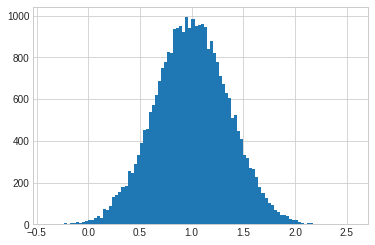

In [13]:
(df0[(df0.success_share==0.3) & (df0.real_diff==1)].test_mean - df0[(df0.success_share==0.3) & (df0.real_diff==1)].control_mean).hist(bins=100)

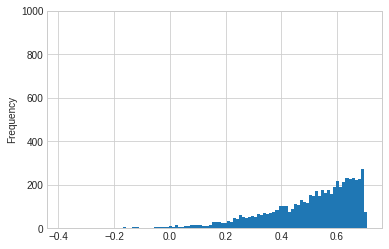

In [14]:
(df0[(df0.success_share==0.3) & (df0.real_diff==1) & (df0.statsig95==0)].test_mean - df0[(df0.success_share==0.3) & (df0.real_diff==1)& (df0.statsig95==0)].control_mean).plot.hist(bins=100, ylim=(0,1000))

In [15]:
columns = ['ci','success_share', 'frr']
data2 = []
for  success_share in [0.1, 0.2, 0.3, 0.4, 0.5]:
  df1 = df0[df0.success_share==success_share]
  data2.append(["95", success_share,  df1[(df1.real_diff==1) & (df1.statsig95==1) & (df1.test_higher_control)].statsig95.count() / df1[df1.real_diff==1].statsig95.count()])
  data2.append(["90", success_share,  df1[(df1.real_diff==1) & (df1.statsig90==1) & (df1.test_higher_control)].statsig90.count() / df1[df1.real_diff==1].statsig90.count()])
  data2.append(["80", success_share,  df1[(df1.real_diff==1) & (df1.statsig80==1) & (df1.test_higher_control)].statsig80.count() / df1[df1.real_diff==1].statsig80.count()])

In [16]:
data2
df1 = pd.DataFrame(data2, columns=columns)
df1

,ci,success_share,frr
0,95,0.1,0.808427
1,90,0.1,0.880974
2,80,0.1,0.936546
3,95,0.2,0.801922
4,90,0.2,0.878346
5,80,0.2,0.938921
6,95,0.3,0.800454
7,90,0.3,0.876964
8,80,0.3,0.935797
9,95,0.4,0.798545


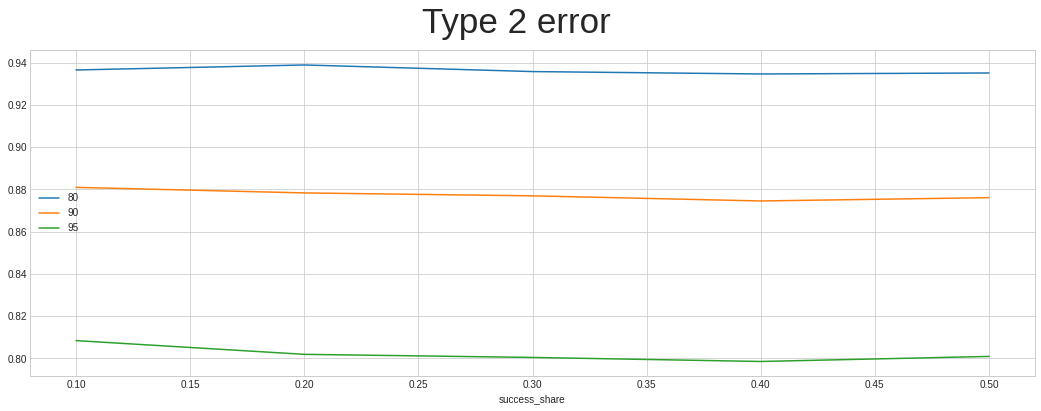

In [17]:
fig, ax = plt.subplots()
for label, grp in df1.groupby('ci'):
    grp.plot(x = 'success_share', y = 'frr',ax = ax, label = label)
    fig.set_size_inches(18, 6)
#     ax.get_legend()
plt.suptitle('Type 2 error', fontsize=35 );